In [36]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

import random
import time
from collections import defaultdict

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

In [37]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()


In [38]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    """
    def policy_fn(observation):
        return int(np.random.rand() * nA) if np.random.rand() < epsilon else np.argmax(Q[observation])
    return policy_fn

100%|██████████| 1000/1000 [00:00<00:00, 2343.87it/s]


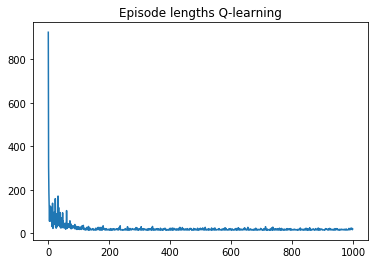

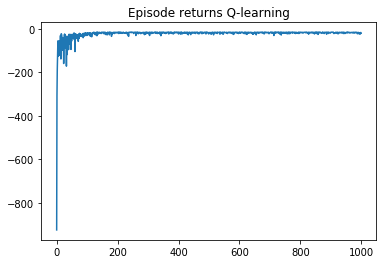

In [39]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        #raise NotImplementedError()
        
        s = env.reset()
        done = False
        while not done:
            a = policy(s)
            #prob, next_s, r, done = env.P[s][a][0]
            next_s, r, done, _ = env.step(a)
            maxQ  = max([Q[next_s][action] for action in range(env.nA)])
            Q[s][a] += alpha * (r + discount_factor*maxQ - Q[s][a])
            s = next_s
            i+=1
            R+=r
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_q_learning)
plt.title('Episode lengths Q-learning')
plt.show()
plt.plot(episode_returns_q_learning)
plt.title('Episode returns Q-learning')
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 1121.11it/s]


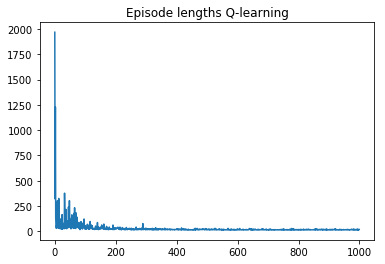

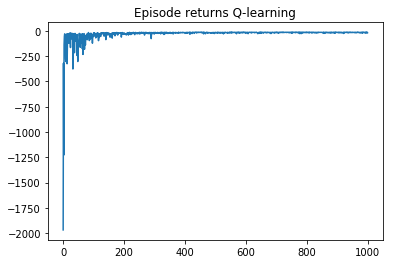

In [40]:
def double_q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q1=None, Q2 = None, Qsum = None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q1 is None:
        Q1 = defaultdict(lambda: np.zeros(env.action_space.n))
    if Q2 is None:
        Q2 = defaultdict(lambda: np.zeros(env.action_space.n))
    if Qsum is None:
        Qsum = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Qsum, epsilon, env.action_space.n)
    

    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # YOUR CODE HERE
        #raise NotImplementedError()
        
        s = env.reset()
        done = False
        while not done:
            a = policy(s)
            #prob, next_s, r, done = env.P[s][a][0]
            next_s, r, done, _ = env.step(a)
            coin_toss = random.randint(0, 1)
            if (coin_toss == 0):
                maxQ  = max([Q2[next_s][action] for action in range(env.nA)])
                Q1[s][a] += alpha * (r + discount_factor*maxQ - Q1[s][a])
            else:
                maxQ  = max([Q1[next_s][action] for action in range(env.nA)])
                Q2[s][a] += alpha * (r + discount_factor*maxQ - Q2[s][a])
            
            Qsum[s][a] = (Q1[s][a]+ Q2[s][a])/2
            s = next_s
            i+=1
            R+=r
        
        stats.append((i, R))
    episode_lengths, episode_returns = zip(*stats)
    return Qsum, Q1, Q2, (episode_lengths, episode_returns)

Qsum_dql, Q1_dql, Q2_dql, (episode_lengths_q_learning, episode_returns_q_learning) = double_q_learning(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_q_learning)
plt.title('Episode lengths Q-learning')
plt.show()
plt.plot(episode_returns_q_learning)
plt.title('Episode returns Q-learning')
plt.show()

100%|██████████| 500/500 [00:00<00:00, 1039.19it/s]


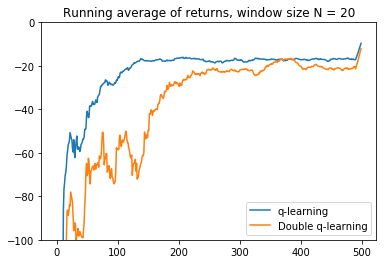

In [41]:
Q_ql, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 500, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None)
Q_dql,_, _, (episode_lengths_q_learning, episode_returns_dq_learning) = double_q_learning(env, 500, discount_factor=1.0, alpha=0.5, epsilon=0.1)


plt.plot(np.convolve(episode_returns_q_learning, np.ones((20,))/20, mode='same'), label="q-learning")
plt.plot(np.convolve(episode_returns_dq_learning, np.ones((20,))/20, mode='same'), label='Double q-learning')
plt.legend()
plt.title('Running average of returns, window size N = 20')
plt.ylim(-100, 0)
plt.show()

In [42]:
def greedy_policy(Q, nA):
    """
    Creates a greedy policy based on a given Q-function and epsilon.
    """
    def policy_fn(observation):
        return np.argmax(Q[observation])
    return policy_fn

def evaluate_policy(env, Q):    

    # The greedy policy we're following
    policy = greedy_policy(Q, env.action_space.n)
       
    i = 0
    R = 0
    s = env.reset()
    done = False
    
    while not done:
            a = policy(s)
            prob, next_s, r, done = env.P[s][a][0]
            s = next_s
            i+=1
            R+=r
            if i>10000:
                break


    episode_length, episode_return = i, R
    return (episode_length, episode_return)


def get_statistics(env, train_steps = 1000, test_steps = 30, df=1.0, al=0.5, eps=0.1, type_learning = 'ql', ):
    episode_lengths = []
    episode_returns = []
    
    for i in range(test_steps):
        if type_learning == 'dql':
            Q, _, _, _ = double_q_learning(env, train_steps, discount_factor=df, alpha=al, epsilon=eps)
        if type_learning == 'ql':
            Q, _ = q_learning(env, train_steps,  discount_factor=df, alpha=al, epsilon=eps, Q=None)
        
        episode_length, episode_return = evaluate_policy(env, Q)
        episode_lengths.append(episode_length)
        episode_returns.append(episode_return)
        
    return (episode_lengths, episode_returns)

# windy grid world

### train episodes = 300


100%|██████████| 300/300 [00:00<00:00, 1175.80it/s]


EPISODES  300   alpha  0.5
Q-learning  [-15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0]
Double Q-learning  [-10001.0, -10001.0, -10001.0, -10001.0, -18.0, -10001.0, -16.0, -10001.0, -10001.0, -10001.0, -10001.0, -15.0, -10001.0, -15.0, -16.0, -16.0, -10001.0, -10001.0, -10001.0, -10001.0, -10001.0, -10001.0, -10001.0, -18.0, -10001.0, -10001.0, -10001.0, -10001.0, -15.0, -18.0]
Double Q diverged  21  times , out of  30  total runs.
Q-learning diverged  0  times , out of  30  total runs.


Double Q, when converged: mean returns =  -16.333333333333332  with std =  1.247219128924647
Q-learning, when converged: mean returns =  -15.0  with std =  0.0
The difference in performance is significant, p-value =  0.008069998383984606


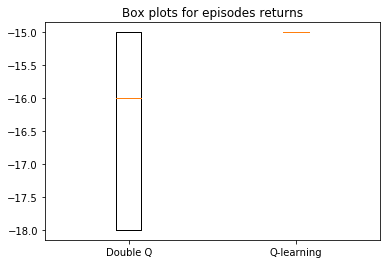

In [43]:
test_steps = 30
train_steps = 300
al=0.5

(episode_lengths_dql, episode_returns_dql) = get_statistics(env, train_steps = train_steps, test_steps = test_steps, type_learning = 'dql', df=1.0, al=0.5, eps=0.1)
(episode_lengths_ql, episode_returns_ql) = get_statistics(env, train_steps = train_steps, test_steps = test_steps, type_learning = 'ql', df=1.0, al=0.5, eps=0.1)

print('EPISODES ', train_steps, '  alpha ', al)
print('Q-learning ', episode_returns_ql)
#print(episode_lengths_q_learning)
print('Double Q-learning ', episode_returns_dql)
#print(episode_lengths_sarsa)


print('Double Q diverged ', len([i for i in episode_returns_dql if i <-10000]),' times , out of ',test_steps,' total runs.')
print('Q-learning diverged ', len([i for i in episode_returns_ql if i <-10000]),' times , out of ',test_steps,' total runs.')
episode_returns_dql_converged = [i for i in episode_returns_dql if i >-10000]
episode_returns_ql_converged = [i for i in episode_returns_ql if i >-10000]
print('\n')
print('Double Q, when converged: mean returns = ',np.mean(episode_returns_dql_converged), ' with std = ', np.std(episode_returns_dql_converged))
print('Q-learning, when converged: mean returns = ',np.mean(episode_returns_ql_converged), ' with std = ', np.std(episode_returns_ql_converged))


from scipy import stats
min_len = min(len(episode_returns_dql_converged), len(episode_returns_ql_converged))
p_val = stats.ttest_ind(episode_returns_dql_converged[:min_len], episode_returns_ql_converged[0:min_len])[1]
if p_val<0.05:
    print('The difference in performance is significant, p-value = ', p_val)
else:
    print('The difference in performance is not significant, p-value = ', p_val)
    

#episode_returns_sarsa[episode_returns_sarsa < 100000]
#len([i for i in episode_returns_dql if i >-10000])
fig1, ax1 = plt.subplots()
ax1.set_title('Box plots for episodes returns')

data = [episode_returns_dql_converged, episode_returns_ql_converged]
ax1.boxplot(data)
ax1.set_xticklabels(['Double Q', 'Q-learning']);

### train episodes = 500


100%|██████████| 500/500 [00:00<00:00, 1318.57it/s]


EPISODES  500   alpha  0.5
Q-learning  [-15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0]
Double Q-learning  [-16.0, -16.0, -15.0, -15.0, -10001.0, -17.0, -18.0, -15.0, -10001.0, -15.0, -15.0, -15.0, -10001.0, -20.0, -16.0, -15.0, -10001.0, -16.0, -15.0, -16.0, -15.0, -15.0, -15.0, -17.0, -16.0, -15.0, -15.0, -15.0, -15.0, -10001.0]
Double Q diverged  5  times , out of  30  total runs.
Q-learning diverged  0  times , out of  30  total runs.


Double Q, when converged: mean returns =  -15.72  with std =  1.1838918869558992
Q-learning, when converged: mean returns =  -15.0  with std =  0.0
The difference in performance is significant, p-value =  0.004521120330292787


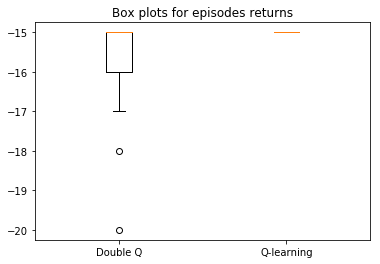

In [44]:
test_steps = 30
train_steps = 500
al=0.5

(episode_lengths_dql, episode_returns_dql) = get_statistics(env, train_steps = train_steps, test_steps = test_steps, type_learning = 'dql', df=1.0, al=0.5, eps=0.1)
(episode_lengths_ql, episode_returns_ql) = get_statistics(env, train_steps = train_steps, test_steps = test_steps, type_learning = 'ql', df=1.0, al=0.5, eps=0.1)

print('EPISODES ', train_steps, '  alpha ', al)
print('Q-learning ', episode_returns_ql)
#print(episode_lengths_q_learning)
print('Double Q-learning ', episode_returns_dql)
#print(episode_lengths_sarsa)


print('Double Q diverged ', len([i for i in episode_returns_dql if i <-10000]),' times , out of ',test_steps,' total runs.')
print('Q-learning diverged ', len([i for i in episode_returns_ql if i <-10000]),' times , out of ',test_steps,' total runs.')
episode_returns_dql_converged = [i for i in episode_returns_dql if i >-10000]
episode_returns_ql_converged = [i for i in episode_returns_ql if i >-10000]
print('\n')
print('Double Q, when converged: mean returns = ',np.mean(episode_returns_dql_converged), ' with std = ', np.std(episode_returns_dql_converged))
print('Q-learning, when converged: mean returns = ',np.mean(episode_returns_ql_converged), ' with std = ', np.std(episode_returns_ql_converged))


from scipy import stats
min_len = min(len(episode_returns_dql_converged), len(episode_returns_ql_converged))
p_val = stats.ttest_ind(episode_returns_dql_converged[:min_len], episode_returns_ql_converged[0:min_len])[1]
if p_val<0.05:
    print('The difference in performance is significant, p-value = ', p_val)
else:
    print('The difference in performance is not significant, p-value = ', p_val)
    

#episode_returns_sarsa[episode_returns_sarsa < 100000]
#len([i for i in episode_returns_dql if i >-10000])
fig1, ax1 = plt.subplots()
ax1.set_title('Box plots for episodes returns')

data = [episode_returns_dql_converged, episode_returns_ql_converged]
ax1.boxplot(data)
ax1.set_xticklabels(['Double Q', 'Q-learning']);

### train episodes = 1000


100%|██████████| 1000/1000 [00:00<00:00, 2721.39it/s]


EPISODES  1000   alpha  0.5
Q-learning  [-15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0]
Double Q-learning  [-17.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -16.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -16.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0]
Double Q diverged  0  times , out of  30  total runs.
Q-learning diverged  0  times , out of  30  total runs.


Double Q, when converged: mean returns =  -15.133333333333333  with std =  0.42687494916218993
Q-learning, when converged: mean returns =  -15.0  with std =  0.0
The difference in performance is not significant, p-value =  0.09793762338954595


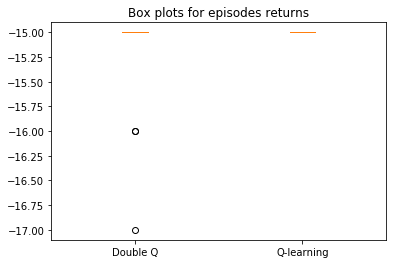

In [45]:
test_steps = 30
train_steps = 1000
al=0.5

(episode_lengths_dql, episode_returns_dql) = get_statistics(env, train_steps = train_steps, test_steps = test_steps, type_learning = 'dql', df=1.0, al=0.5, eps=0.1)
(episode_lengths_ql, episode_returns_ql) = get_statistics(env, train_steps = train_steps, test_steps = test_steps, type_learning = 'ql', df=1.0, al=0.5, eps=0.1)

print('EPISODES ', train_steps, '  alpha ', al)
print('Q-learning ', episode_returns_ql)
#print(episode_lengths_q_learning)
print('Double Q-learning ', episode_returns_dql)
#print(episode_lengths_sarsa)


print('Double Q diverged ', len([i for i in episode_returns_dql if i <-10000]),' times , out of ',test_steps,' total runs.')
print('Q-learning diverged ', len([i for i in episode_returns_ql if i <-10000]),' times , out of ',test_steps,' total runs.')
episode_returns_dql_converged = [i for i in episode_returns_dql if i >-10000]
episode_returns_ql_converged = [i for i in episode_returns_ql if i >-10000]
print('\n')
print('Double Q, when converged: mean returns = ',np.mean(episode_returns_dql_converged), ' with std = ', np.std(episode_returns_dql_converged))
print('Q-learning, when converged: mean returns = ',np.mean(episode_returns_ql_converged), ' with std = ', np.std(episode_returns_ql_converged))


from scipy import stats
min_len = min(len(episode_returns_dql_converged), len(episode_returns_ql_converged))
p_val = stats.ttest_ind(episode_returns_dql_converged[:min_len], episode_returns_ql_converged[0:min_len])[1]
if p_val<0.05:
    print('The difference in performance is significant, p-value = ', p_val)
else:
    print('The difference in performance is not significant, p-value = ', p_val)
    

#episode_returns_sarsa[episode_returns_sarsa < 100000]
#len([i for i in episode_returns_dql if i >-10000])
fig1, ax1 = plt.subplots()
ax1.set_title('Box plots for episodes returns')

data = [episode_returns_dql_converged, episode_returns_ql_converged]
ax1.boxplot(data)
ax1.set_xticklabels(['Double Q', 'Q-learning']);

### train episodes = 2000


100%|██████████| 2000/2000 [00:00<00:00, 3033.66it/s]


EPISODES  2000   alpha  0.5
Q-learning  [-15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0]
Double Q-learning  [-15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0]
Double Q diverged  0  times , out of  30  total runs.
Q-learning diverged  0  times , out of  30  total runs.


Double Q, when converged: mean returns =  -15.0  with std =  0.0
Q-learning, when converged: mean returns =  -15.0  with std =  0.0
The difference in performance is not significant, p-value =  nan


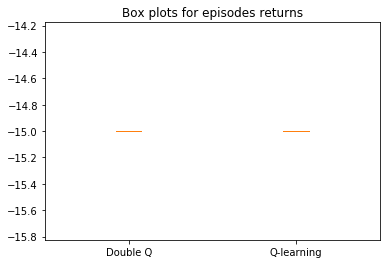

In [17]:
test_steps = 30
train_steps = 2000
al=0.5

(episode_lengths_dql, episode_returns_dql) = get_statistics(env, train_steps = train_steps, test_steps = test_steps, type_learning = 'dql', df=1.0, al=0.5, eps=0.1)
(episode_lengths_ql, episode_returns_ql) = get_statistics(env, train_steps = train_steps, test_steps = test_steps, type_learning = 'ql', df=1.0, al=0.5, eps=0.1)

print('EPISODES ', train_steps, '  alpha ', al)
print('Q-learning ', episode_returns_ql)
#print(episode_lengths_q_learning)
print('Double Q-learning ', episode_returns_dql)
#print(episode_lengths_sarsa)


print('Double Q diverged ', len([i for i in episode_returns_dql if i <-10000]),' times , out of ',test_steps,' total runs.')
print('Q-learning diverged ', len([i for i in episode_returns_ql if i <-10000]),' times , out of ',test_steps,' total runs.')
episode_returns_dql_converged = [i for i in episode_returns_dql if i >-10000]
episode_returns_ql_converged = [i for i in episode_returns_ql if i >-10000]
print('\n')
print('Double Q, when converged: mean returns = ',np.mean(episode_returns_dql_converged), ' with std = ', np.std(episode_returns_dql_converged))
print('Q-learning, when converged: mean returns = ',np.mean(episode_returns_ql_converged), ' with std = ', np.std(episode_returns_ql_converged))


from scipy import stats
min_len = min(len(episode_returns_dql_converged), len(episode_returns_ql_converged))
p_val = stats.ttest_ind(episode_returns_dql_converged[:min_len], episode_returns_ql_converged[0:min_len])[1]
if p_val<0.05:
    print('The difference in performance is significant, p-value = ', p_val)
else:
    print('The difference in performance is not significant, p-value = ', p_val)
    

#episode_returns_sarsa[episode_returns_sarsa < 100000]
#len([i for i in episode_returns_dql if i >-10000])
fig1, ax1 = plt.subplots()
ax1.set_title('Box plots for episodes returns')

data = [episode_returns_dql_converged, episode_returns_ql_converged]
ax1.boxplot(data)
ax1.set_xticklabels(['Double Q', 'Q-learning']);

### train episodes = 4000


100%|██████████| 4000/4000 [00:01<00:00, 2856.19it/s]


EPISODES  4000   alpha  0.5
Q-learning  [-15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0]
Double Q-learning  [-15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0, -15.0]
Double Q diverged  0  times , out of  30  total runs.
Q-learning diverged  0  times , out of  30  total runs.


Double Q, when converged: mean returns =  -15.0  with std =  0.0
Q-learning, when converged: mean returns =  -15.0  with std =  0.0
The difference in performance is not significant, p-value =  nan


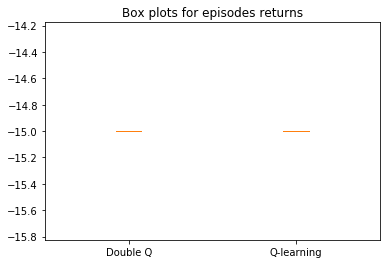

In [22]:
test_steps = 30
train_steps = 4000
al=0.5

(episode_lengths_dql, episode_returns_dql) = get_statistics(env, train_steps = train_steps, test_steps = test_steps, type_learning = 'dql', df=1.0, al=0.5, eps=0.1)
(episode_lengths_ql, episode_returns_ql) = get_statistics(env, train_steps = train_steps, test_steps = test_steps, type_learning = 'ql', df=1.0, al=0.5, eps=0.1)

print('EPISODES ', train_steps, '  alpha ', al)
print('Q-learning ', episode_returns_ql)
#print(episode_lengths_q_learning)
print('Double Q-learning ', episode_returns_dql)
#print(episode_lengths_sarsa)


print('Double Q diverged ', len([i for i in episode_returns_dql if i <-10000]),' times , out of ',test_steps,' total runs.')
print('Q-learning diverged ', len([i for i in episode_returns_ql if i <-10000]),' times , out of ',test_steps,' total runs.')
episode_returns_dql_converged = [i for i in episode_returns_dql if i >-10000]
episode_returns_ql_converged = [i for i in episode_returns_ql if i >-10000]
print('\n')
print('Double Q, when converged: mean returns = ',np.mean(episode_returns_dql_converged), ' with std = ', np.std(episode_returns_dql_converged))
print('Q-learning, when converged: mean returns = ',np.mean(episode_returns_ql_converged), ' with std = ', np.std(episode_returns_ql_converged))


from scipy import stats
min_len = min(len(episode_returns_dql_converged), len(episode_returns_ql_converged))
p_val = stats.ttest_ind(episode_returns_dql_converged[:min_len], episode_returns_ql_converged[0:min_len])[1]
if p_val<0.05:
    print('The difference in performance is significant, p-value = ', p_val)
else:
    print('The difference in performance is not significant, p-value = ', p_val)
    

#episode_returns_sarsa[episode_returns_sarsa < 100000]
#len([i for i in episode_returns_dql if i >-10000])
fig1, ax1 = plt.subplots()
ax1.set_title('Box plots for episodes returns')

data = [episode_returns_dql_converged, episode_returns_ql_converged]
ax1.boxplot(data)
ax1.set_xticklabels(['Double Q', 'Q-learning']);

So double q-learning(DQL) requires more episodes to converge than q-learning(QL). For 300 episodes DQL diverged 20 times out of 30 runs, and found optimal policy only in 5 runs, while QL found optimal policy all 30 times. Increasing number of episodes solves this issues, so when training with more than 2000 episdoes DQL finds optimal policy all 30 times. 

In [50]:
from cliff import CliffWalkingEnv
env = CliffWalkingEnv()

# Cliff walking 

### train episodes = 300


100%|██████████| 300/300 [00:00<00:00, 2182.74it/s]


EPISODES  300   alpha  0.5
Q-learning  [-13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13]
Double Q-learning  [-13, -13, -10001, -13, -13, -15, -13, -13, -13, -13, -10001, -13, -13, -13, -10001, -13, -13, -13, -13, -13, -15, -13, -13, -13, -13, -13, -15, -13, -13, -15]
Double Q diverged  3  times , out of  30  total runs.
Q-learning diverged  0  times , out of  30  total runs.


Double Q, when converged: mean returns =  -13.296296296296296  with std =  0.7104935590092918
Q-learning, when converged: mean returns =  -13.0  with std =  0.0
The difference in performance is significant, p-value =  0.03823258168307807


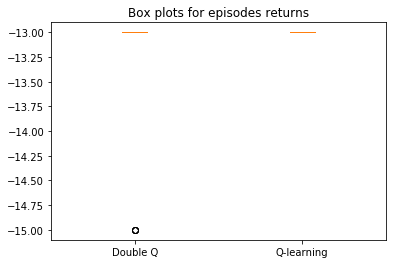

In [51]:
test_steps = 30
train_steps = 300
al=0.5

(episode_lengths_dql, episode_returns_dql) = get_statistics(env, train_steps = train_steps, test_steps = test_steps, type_learning = 'dql', df=1.0, al=0.5, eps=0.1)
(episode_lengths_ql, episode_returns_ql) = get_statistics(env, train_steps = train_steps, test_steps = test_steps, type_learning = 'ql', df=1.0, al=0.5, eps=0.1)

print('EPISODES ', train_steps, '  alpha ', al)
print('Q-learning ', episode_returns_ql)
#print(episode_lengths_q_learning)
print('Double Q-learning ', episode_returns_dql)
#print(episode_lengths_sarsa)


print('Double Q diverged ', len([i for i in episode_returns_dql if i <-10000]),' times , out of ',test_steps,' total runs.')
print('Q-learning diverged ', len([i for i in episode_returns_ql if i <-10000]),' times , out of ',test_steps,' total runs.')
episode_returns_dql_converged = [i for i in episode_returns_dql if i >-10000]
episode_returns_ql_converged = [i for i in episode_returns_ql if i >-10000]
print('\n')
print('Double Q, when converged: mean returns = ',np.mean(episode_returns_dql_converged), ' with std = ', np.std(episode_returns_dql_converged))
print('Q-learning, when converged: mean returns = ',np.mean(episode_returns_ql_converged), ' with std = ', np.std(episode_returns_ql_converged))


from scipy import stats
min_len = min(len(episode_returns_dql_converged), len(episode_returns_ql_converged))
p_val = stats.ttest_ind(episode_returns_dql_converged[:min_len], episode_returns_ql_converged[0:min_len])[1]
if p_val<0.05:
    print('The difference in performance is significant, p-value = ', p_val)
else:
    print('The difference in performance is not significant, p-value = ', p_val)
    

#episode_returns_sarsa[episode_returns_sarsa < 100000]
#len([i for i in episode_returns_dql if i >-10000])
fig1, ax1 = plt.subplots()
ax1.set_title('Box plots for episodes returns')

data = [episode_returns_dql_converged, episode_returns_ql_converged]
ax1.boxplot(data)
ax1.set_xticklabels(['Double Q', 'Q-learning']);

### train episodes = 500


100%|██████████| 500/500 [00:00<00:00, 2703.37it/s]


EPISODES  500   alpha  0.5
Q-learning  [-13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13]
Double Q-learning  [-13, -13, -13, -13, -13, -13, -13, -13, -13, -15, -13, -13, -13, -13, -13, -13, -10001, -13, -13, -13, -13, -17, -13, -13, -13, -13, -15, -13, -15, -13]
Double Q diverged  1  times , out of  30  total runs.
Q-learning diverged  0  times , out of  30  total runs.


Double Q, when converged: mean returns =  -13.344827586206897  with std =  0.9201147630431953
Q-learning, when converged: mean returns =  -13.0  with std =  0.0
The difference in performance is not significant, p-value =  0.052271606548980644


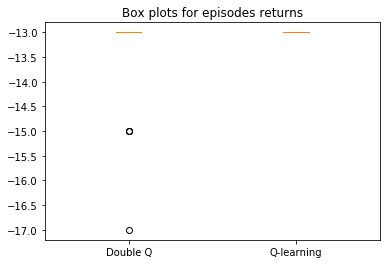

In [52]:
test_steps = 30
train_steps = 500
al=0.5

(episode_lengths_dql, episode_returns_dql) = get_statistics(env, train_steps = train_steps, test_steps = test_steps, type_learning = 'dql', df=1.0, al=0.5, eps=0.1)
(episode_lengths_ql, episode_returns_ql) = get_statistics(env, train_steps = train_steps, test_steps = test_steps, type_learning = 'ql', df=1.0, al=0.5, eps=0.1)

print('EPISODES ', train_steps, '  alpha ', al)
print('Q-learning ', episode_returns_ql)
#print(episode_lengths_q_learning)
print('Double Q-learning ', episode_returns_dql)
#print(episode_lengths_sarsa)


print('Double Q diverged ', len([i for i in episode_returns_dql if i <-10000]),' times , out of ',test_steps,' total runs.')
print('Q-learning diverged ', len([i for i in episode_returns_ql if i <-10000]),' times , out of ',test_steps,' total runs.')
episode_returns_dql_converged = [i for i in episode_returns_dql if i >-10000]
episode_returns_ql_converged = [i for i in episode_returns_ql if i >-10000]
print('\n')
print('Double Q, when converged: mean returns = ',np.mean(episode_returns_dql_converged), ' with std = ', np.std(episode_returns_dql_converged))
print('Q-learning, when converged: mean returns = ',np.mean(episode_returns_ql_converged), ' with std = ', np.std(episode_returns_ql_converged))


from scipy import stats
min_len = min(len(episode_returns_dql_converged), len(episode_returns_ql_converged))
p_val = stats.ttest_ind(episode_returns_dql_converged[:min_len], episode_returns_ql_converged[0:min_len])[1]
if p_val<0.05:
    print('The difference in performance is significant, p-value = ', p_val)
else:
    print('The difference in performance is not significant, p-value = ', p_val)
    

#episode_returns_sarsa[episode_returns_sarsa < 100000]
#len([i for i in episode_returns_dql if i >-10000])
fig1, ax1 = plt.subplots()
ax1.set_title('Box plots for episodes returns')

data = [episode_returns_dql_converged, episode_returns_ql_converged]
ax1.boxplot(data)
ax1.set_xticklabels(['Double Q', 'Q-learning']);

### train episodes = 1000


100%|██████████| 1000/1000 [00:00<00:00, 2997.84it/s]


EPISODES  1000   alpha  0.5
Q-learning  [-13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13]
Double Q-learning  [-13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13, -13]
Double Q diverged  0  times , out of  30  total runs.
Q-learning diverged  0  times , out of  30  total runs.


Double Q, when converged: mean returns =  -13.0  with std =  0.0
Q-learning, when converged: mean returns =  -13.0  with std =  0.0
The difference in performance is not significant, p-value =  nan


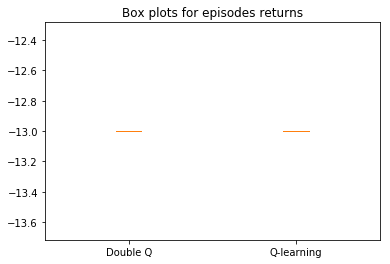

In [53]:
test_steps = 30
train_steps = 1000
al=0.5

(episode_lengths_dql, episode_returns_dql) = get_statistics(env, train_steps = train_steps, test_steps = test_steps, type_learning = 'dql', df=1.0, al=0.5, eps=0.1)
(episode_lengths_ql, episode_returns_ql) = get_statistics(env, train_steps = train_steps, test_steps = test_steps, type_learning = 'ql', df=1.0, al=0.5, eps=0.1)

print('EPISODES ', train_steps, '  alpha ', al)
print('Q-learning ', episode_returns_ql)
#print(episode_lengths_q_learning)
print('Double Q-learning ', episode_returns_dql)
#print(episode_lengths_sarsa)


print('Double Q diverged ', len([i for i in episode_returns_dql if i <-10000]),' times , out of ',test_steps,' total runs.')
print('Q-learning diverged ', len([i for i in episode_returns_ql if i <-10000]),' times , out of ',test_steps,' total runs.')
episode_returns_dql_converged = [i for i in episode_returns_dql if i >-10000]
episode_returns_ql_converged = [i for i in episode_returns_ql if i >-10000]
print('\n')
print('Double Q, when converged: mean returns = ',np.mean(episode_returns_dql_converged), ' with std = ', np.std(episode_returns_dql_converged))
print('Q-learning, when converged: mean returns = ',np.mean(episode_returns_ql_converged), ' with std = ', np.std(episode_returns_ql_converged))


from scipy import stats
min_len = min(len(episode_returns_dql_converged), len(episode_returns_ql_converged))
p_val = stats.ttest_ind(episode_returns_dql_converged[:min_len], episode_returns_ql_converged[0:min_len])[1]
if p_val<0.05:
    print('The difference in performance is significant, p-value = ', p_val)
else:
    print('The difference in performance is not significant, p-value = ', p_val)
    

#episode_returns_sarsa[episode_returns_sarsa < 100000]
#len([i for i in episode_returns_dql if i >-10000])
fig1, ax1 = plt.subplots()
ax1.set_title('Box plots for episodes returns')

data = [episode_returns_dql_converged, episode_returns_ql_converged]
ax1.boxplot(data)
ax1.set_xticklabels(['Double Q', 'Q-learning']);